# DRL Crypto Portfolio 

This project demonstrates the use of deep reinforcement learning (PPO) for adaptive crypto portfolio optimization using a custom Gymnasium environment. The approach balances between maximizing returns and managing risk via a differential Sharpe reward function. 

📚 **Reference**  
> This implementation is inspired by the differential Sharpe optimization method proposed in:  
>
> Srijan Sood, Kassiani Papasotiriou, Marius Vaiciulis, and Tucker Balch. (2023).
> *Deep Reinforcement Learning for Optimal Portfolio Allocation: A Comparative Study with Mean-Variance Optimization*.
> In Proceedings of the ICAPS 2023 Workshop on AI in Finance (FinPlan).
> [PDF](https://icaps23.icaps-conference.org/papers/finplan/FinPlan23_paper_4.pdf)
>
> In this work, the reward is based on the differential form of the Sharpe ratio, allowing the agent to optimize risk-adjusted returns incrementally at each timestep.

In [1]:
# Import required libraries and custom modules.
# The custom environment (PortfolioEnv) simulates portfolio returns over time using price and volatility inputs.
# Stable-Baselines3 PPO is used as the RL agent.
# Evaluation and feature engineering utilities are modularized in the `drl_portfolio` package.

# === Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime

import sys
sys.path.append("..")  # current directory

from drl_portfolio.env import PortfolioEnv
from drl_portfolio.features import generate_features
from drl_portfolio.utils import generate_time_windows, plot_ppo_weights_over_time, plot_weight_statistics

## 1. Download and save the crypto data from Binance

- The price dataframe contains 4-hour interval OHLC data for multiple crypto assets.

In [2]:
# Set to `False' if you want to Download from Binance. 
# If you already downloaded data before, set to `True'.

cryp_data_downloaded = True


### 1.1. Download and save the crypto data from Binance

- Get the close price for crypto assets with 4 hour interval

In [3]:
# Download the data from Binance
if not cryp_data_downloaded:
    from binance.client import Client
    from datetime import datetime, timedelta
    import time

    # No need for API keys for public data
    client = Client(tld='US')

    def get_binance_ohlcv(symbol: str, interval: str = '1d', start: str = '1 Jan 2020'):
        """
        Get historical OHLCV data from Binance for a given symbol.
        """
        bars = client.get_historical_klines(symbol, interval, start)
        df = pd.DataFrame(bars, columns=[
            'open_time', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        df['date'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index('date', inplace=True)
        df = df[['close']].astype(float)
        return df

    # Choose symbols (must be valid Binance trading pairs)
    symbols = symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LTCUSDT', 'ADAUSDT', 'NEOUSDT', 'XLMUSDT']
    start_date = '2020-01-01'
    dfs = []

    freq='4h'

    for symbol in symbols:
        df = get_binance_ohlcv(symbol, interval=freq, start=start_date)
        df.rename(columns={'close': symbol}, inplace=True)
        dfs.append(df)
        time.sleep(0.5)  # Be gentle with the API

    # Merge into single DataFrame
    price_df = pd.concat(dfs, axis=1)
    price_df.to_csv("../data/crypto_data.csv")

# Use pre-downloaded data
else:
    price_df = pd.read_csv("../data/crypto_data.csv", index_col="date", parse_dates=True)

### 1.2. Data validation

- Let's see if the price data looks as expected.

In [4]:
# Check the date, columns, values
print("========= Checking the first 5 rows =========")
pprint(price_df.head(5))
print("========= Checking the last 5 rows =========")
pprint(price_df.tail(5))



========= Checking the first 5 rows =========
                     BTCUSDT  ETHUSDT  BNBUSDT  LTCUSDT  ADAUSDT  NEOUSDT  \
date                                                                        
2020-01-01 00:00:00  7230.71   130.18  13.8159    41.58  0.03308    8.736   
2020-01-01 04:00:00  7205.50   130.52  13.7648    41.55  0.03320    8.716   
2020-01-01 08:00:00  7195.80   130.84  13.7162    41.67  0.03321    8.791   
2020-01-01 12:00:00  7233.02   131.84  13.7958    41.89  0.03357    8.905   
2020-01-01 16:00:00  7223.72   131.98  13.7270    41.79  0.03361    8.940   

                     XLMUSDT  
date                          
2020-01-01 00:00:00  0.04515  
2020-01-01 04:00:00  0.04493  
2020-01-01 08:00:00  0.04509  
2020-01-01 12:00:00  0.04542  
2020-01-01 16:00:00  0.04547  
========= Checking the last 5 rows =========
                      BTCUSDT  ETHUSDT  BNBUSDT  LTCUSDT  ADAUSDT  NEOUSDT  \
date                                                                      

- Below figure plots the price history for each crypto assets.
- Price is relative to the price on 2020-01-01 for plotting purposes.

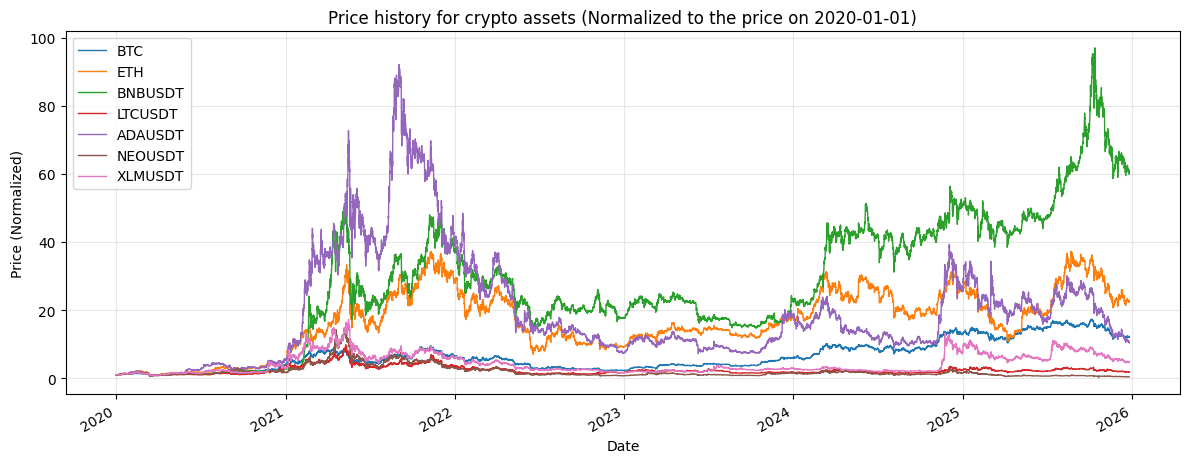

In [5]:
plt.figure(figsize=(12, 5))

plt.plot(price_df['BTCUSDT']/price_df['BTCUSDT'].iloc[0], label="BTC", linewidth=1)
plt.plot(price_df['ETHUSDT']/price_df['ETHUSDT'].iloc[0], label="ETH", linewidth=1)
plt.plot(price_df['BNBUSDT']/price_df['BNBUSDT'].iloc[0], label="BNBUSDT", linewidth=1)
plt.plot(price_df['LTCUSDT']/price_df['LTCUSDT'].iloc[0], label="LTCUSDT", linewidth=1)
plt.plot(price_df['ADAUSDT']/price_df['ADAUSDT'].iloc[0], label="ADAUSDT", linewidth=1)
plt.plot(price_df['NEOUSDT']/price_df['NEOUSDT'].iloc[0], label="NEOUSDT", linewidth=1)
plt.plot(price_df['XLMUSDT']/price_df['XLMUSDT'].iloc[0], label="XLMUSDT", linewidth=1)
  
    
plt.title("Price history for crypto assets (Normalized to the price on 2020-01-01)")
plt.xlabel("Date")
plt.ylabel("Price (Normalized)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

## 2. PPO trainining

In this section, we train a PPO agent from scratch using a sliding window of historical data.
Each window defines a training and test period. The model is trained using the `PortfolioEnv`, which outputs a Sharpe-related reward signal at each timestep.
Training can take several million timesteps depending on the environment length and frequency.

### 2.1. Generate features

- Generate_features() returns (log returns, vol_short, vol_short/vol_long, cross assets std, price) and valid indexs from the price timeseries data.
- Using two lookback sizes, volatility trend can be captured.
- i.e. if vol(3 day rolloing mean) / vol (10 day rolling mean) is small, volatility is in decreasing trend.
- Train RL agent using these features.

In [6]:
lookback_long = 60 # 60 x 4 h ~ 10 days, long lookback for volatility
lookback_short = 20 # 20 x 4 h ~ 3.3 days, short lookback window for volativity 

lookbacks=(lookback_short, lookback_long)

# generate_features from the price data, lookbacks, 
log_returns, vol_feats, prices, valid_idx = generate_features(price_df, lookbacks=lookbacks)


Let's look at the log returns for each assets

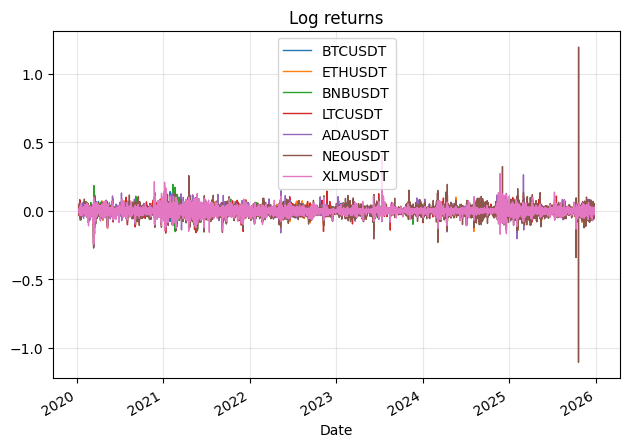

In [7]:
# Plotting log returns
plt.plot(log_returns['BTCUSDT'], label='BTCUSDT', linewidth=1)
plt.plot(log_returns['ETHUSDT'], label='ETHUSDT', linewidth=1)
plt.plot(log_returns['BNBUSDT'], label='BNBUSDT', linewidth=1)
plt.plot(log_returns['LTCUSDT'], label='LTCUSDT', linewidth=1)
plt.plot(log_returns['ADAUSDT'], label='ADAUSDT', linewidth=1)
plt.plot(log_returns['NEOUSDT'], label='NEOUSDT', linewidth=1)
plt.plot(log_returns['XLMUSDT'], label='XLMUSDT', linewidth=1)
plt.title("Log returns")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

- NEOUSDT's log return on 2025-10-25 is consistent with the pricing data, likely due to a market event.
- Note that log return (in practice) will be calculated again on-the-fly during agent training (to prevent "off-by-one" error).

### 2.2. Generate time windows for train and test set. 
Generate windows for train and test data. The model (RL agent) should never see testing data during the training.

In [8]:
windows = generate_time_windows(price_df, train_years=3.5, test_years=0.5)
for i, (tr_start, tr_end, te_start, te_end) in enumerate(windows):
    print(f"Window {i+1}: "
          f"Train {tr_start:%Y-%m-%d} to {tr_end:%Y-%m-%d}, "
          f"Test {te_start:%Y-%m-%d} to {te_end:%Y-%m-%d}")

Window 1: Train 2020-01-01 to 2023-07-01, Test 2023-07-02 to 2023-12-30
Window 2: Train 2020-07-01 to 2023-12-30, Test 2023-12-31 to 2024-06-29
Window 3: Train 2020-12-30 to 2024-06-29, Test 2024-06-30 to 2024-12-28
Window 4: Train 2021-06-30 to 2024-12-28, Test 2024-12-29 to 2025-06-28


Check any invalid values from the price data

In [9]:
for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
    print(f"\n🔍 Window {i+1}: {train_start} to {test_end}")

    # Extract full range (train + val + test)
    window_df = price_df.loc[train_start:test_end]

    # Check per asset
    for symbol in price_df.columns:
        num_nans = window_df[symbol].isna().sum()
        if num_nans > 0:
            print(f"⚠️ {symbol} has {num_nans} missing values in this window")


🔍 Window 1: 2020-01-01 00:00:00 to 2023-12-30 00:00:00

🔍 Window 2: 2020-07-01 00:00:00 to 2024-06-29 00:00:00

🔍 Window 3: 2020-12-30 00:00:00 to 2024-12-28 00:00:00

🔍 Window 4: 2021-06-30 00:00:00 to 2025-06-28 00:00:00


### 2.3. RL agent training 

In [10]:
# imports for PPO training

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback

In [11]:

results = [] # to save test results

# If you're running a fresh training set to `False'
# If you're using saved models, set to `True`
use_saved_models = True#False #True #

# Training happens on a custom vectorized environment across multiple processes.
# PPO is configured with clipped objective and uses GAE for advantage estimation.
# The model is logged to TensorBoard for reward tracking and saved to disk after training.
if not use_saved_models:

    for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
        print(f"\n🌀 Window {i+1}:")
        print(f"Train: {train_start} to {train_end}")
        print(f"Test : {test_start} to {test_end}")

        # === Slice train data ===
        tr_start_i = valid_idx.searchsorted(train_start, side='left')
        tr_end_i   = valid_idx.searchsorted(train_end, side='left')

        log_returns_tv = log_returns[tr_start_i: tr_end_i + 1]
        vol_feats_tv = vol_feats[tr_start_i : tr_end_i + 1]
        prices_tv = prices[tr_start_i : tr_end_i + 1]
        print("training data start idx: ", tr_start_i)
        print("training data end idx: ", tr_end_i)
        
        # === Slice test data ===
        test_start_i = valid_idx.searchsorted(test_start, side='left')
        test_end_i   = valid_idx.searchsorted(test_end, side='left')

        log_returns_test = log_returns[test_start_i: test_end_i + 1]
        vol_feats_test = vol_feats[test_start_i : test_end_i + 1]
        prices_test = prices[test_start_i : test_end_i + 1]

        print("testing data start idx: ", test_start_i)
        print("testing data end idx: ", test_end_i)


        # === Training env (parallelized) ===
        def make_env(i):
            def _init():
                return PortfolioEnv(data=prices_tv, vol_features=vol_feats_tv, max_steps=1024)
            return _init

        vec_env = SubprocVecEnv([make_env(i) for i in range(4)])
        vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.)

        # === PPO model ===
        model = PPO(
            "MlpPolicy",
            vec_env,
            learning_rate=1e-4,
            max_grad_norm=0.5,
            n_steps=2048,
            batch_size=512,
            n_epochs=5,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            ent_coef=0.005, 
            policy_kwargs=dict(
                net_arch=dict(pi=[128, 128], vf=[128, 128])
                ),
            verbose=1,
            tensorboard_log="../results/ppo_logs/"
        )

        print("🔧 Training...")

        eval_env = DummyVecEnv([lambda: PortfolioEnv(data=prices_test, vol_features=vol_feats_test)])
        eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.)
        # Sync stats initially (optional but good practice)
        eval_env.obs_rms = vec_env.obs_rms 

        eval_callback = EvalCallback(
            eval_env,
            best_model_save_path="../results/models/best_model/",
            log_path="../results/logs/",
            eval_freq=50000,        # Check performance every 50k steps
            deterministic=True,
            render=False
        )
        model.learn(total_timesteps=2_000_000, tb_log_name=f"PPO_crypto_window_{i+1}", log_interval=1, callback=eval_callback)
        vec_env.close()

        # === Backtesting ===
        print("🧪 Backtesting...")
        test_env = DummyVecEnv([lambda: PortfolioEnv(data=prices_test, vol_features=vol_feats_test)])
        test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
        test_env.obs_rms = vec_env.obs_rms
        test_env.training = False
        real_test_env = test_env.envs[0]
        obs = test_env.reset()
        done = False

        portfolio_vals = [real_test_env.portfolio_value]
        weights_log = []

        while not done:
            # Predict using the NORMALIZED observation
            action, _ = model.predict(obs, deterministic=True)
            
            # Step the environment
            obs, _, dones, infos = test_env.step(action)

            done = dones[0]
            
            # Log raw values from the real underlying env
            # Note: 'action' from predict is shape (1, n_assets), so use action[0]
            weights = np.exp(action[0]) / np.sum(np.exp(action[0]))
            weights_log.append(weights)

            # 4. Log Portfolio Value (Handle the Reset)
            if done:
                # CRITICAL FIX: Read the final value from 'infos' 
                # because real_test_env.portfolio_value has already reset to 1.0
                try:
                    # Your env.py must put 'final_value' in info['episode']
                    # SB3 wraps info in a list (one per env)
                    final_val = infos[0]["episode"]["final_value"]
                    portfolio_vals.append(final_val)
                except KeyError:
                    # Fallback if your env.py didn't populate info correctly
                    print("⚠️ Warning: Could not find final_value in infos. Using reset value.")
                    portfolio_vals.append(real_test_env.portfolio_value)
            else:
                # Normal case: Read from the live environment
                portfolio_vals.append(real_test_env.portfolio_value)

        results.append({
            "window": i + 1,
            "portfolio_values": portfolio_vals,
            "weights": np.array(weights_log),
            "start_date": test_start,
            "end_date": test_end,
            # Adjust dates index to match length
            "dates": log_returns_test.index[lookbacks[1]: lookbacks[1] + len(weights_log)]
        })

        #print(len(portfolio_vals), len(log_returns_test))
        current_date = datetime.now().strftime("%Y%m%d")
        print(f"✅ Final portfolio value: {portfolio_vals[-1]:.2f}")
        model.save(f"../results/models/ppo_window_{i+1}_2M_{current_date}")
        vec_env.save(f"../results/models/vec_normalized_window_{i+1}_{current_date}.pkl")


# Alternatively, you can skip training and load a pre-trained PPO model saved in the previous step.
else:
    # 1. Generate features on the FULL dataset first (Same as training logic)
    # We do this to ensure valid_idx is consistent and lookbacks are preserved. 
    log_returns, vol_feats, prices, valid_idx = generate_features(price_df, lookbacks=lookbacks)

    for i, (train_start, train_end, test_start, test_end) in enumerate(windows):
        print(f"\n📦 Loading PPO model for Window {i+1}")
        
        # === Slice test data using the global features (Safe Slicing) ===
        test_start_i = valid_idx.searchsorted(test_start, side='left')
        test_end_i   = valid_idx.searchsorted(test_end, side='left')

        log_returns_test = log_returns[test_start_i: test_end_i + 1]
        vol_feats_test   = vol_feats[test_start_i : test_end_i + 1]
        prices_test      = prices[test_start_i : test_end_i + 1]

        # === Setup Environment ===
        # We must wrap it exactly like training
        test_env = DummyVecEnv([lambda: PortfolioEnv(data=prices_test, vol_features=vol_feats_test)])

        # === Load Normalization Statistics ===
        # CRITICAL: You must load the stats saved during training.
        # If you didn't save this file, the model will fail.
        stats_path = f"../results/models/vec_normalized_window_{i+1}_20251227.pkl" # Ensure filename matches

        try:
            test_env = VecNormalize.load(stats_path, test_env)
            test_env.training = False  # Freeze stats (don't learn from test data)
            test_env.norm_reward = False # We want real dollar values, not normalized rewards
        except FileNotFoundError:
            print(f"❌ Error: Could not find {stats_path}. You must save vec_env during training!")
            continue

        # === Load Model ===
        model_path = f"../results/models/ppo_window_{i+1}_2M_20251227" # Ensure filename matches
        model = PPO.load(model_path)

        # === Backtesting Loop ===
        print("🧪 Backtesting...")
        obs = test_env.reset()
        done = False
        
        # Access real env for raw values
        real_test_env = test_env.envs[0]
        portfolio_vals = [real_test_env.portfolio_value]
        weights_log = []

        while not done:
            # Predict using the NORMALIZED observation
            action, _ = model.predict(obs, deterministic=True)
            
            # Step the environment
            obs, _, dones, infos = test_env.step(action)

            done = dones[0]
            
            # Log raw values from the real underlying env
            # Note: 'action' from predict is shape (1, n_assets), so use action[0]
            weights = np.exp(action[0]) / np.sum(np.exp(action[0]))
            weights_log.append(weights)

            # 4. Log Portfolio Value (Handle the Reset)
            if done:
                # CRITICAL FIX: Read the final value from 'infos' 
                # because real_test_env.portfolio_value has already reset to 1.0
                try:
                    # Your env.py must put 'final_value' in info['episode']
                    # SB3 wraps info in a list (one per env)
                    final_val = infos[0]["episode"]["final_value"]
                    portfolio_vals.append(final_val)
                except KeyError:
                    # Fallback if your env.py didn't populate info correctly
                    print("⚠️ Warning: Could not find final_value in infos. Using reset value.")
                    portfolio_vals.append(real_test_env.portfolio_value)
            else:
                # Normal case: Read from the live environment
                portfolio_vals.append(real_test_env.portfolio_value)

        results.append({
            "window": i + 1,
            "portfolio_values": portfolio_vals,
            "weights": np.array(weights_log),
            "start_date": test_start,
            "end_date": test_end,
            "dates": log_returns_test.index[lookbacks[1]: lookbacks[1] + len(weights_log)]
        })

        print(f"✅ Final portfolio value: {portfolio_vals[-1]:.2f}")


📦 Loading PPO model for Window 1
🧪 Backtesting...
✅ Final portfolio value: 1.25

📦 Loading PPO model for Window 2
🧪 Backtesting...
✅ Final portfolio value: 1.18

📦 Loading PPO model for Window 3
🧪 Backtesting...
✅ Final portfolio value: 3.08

📦 Loading PPO model for Window 4
🧪 Backtesting...
✅ Final portfolio value: 1.75


Let's take a look at the test weights for window1. 

📊 Plotting PPO weights over time...


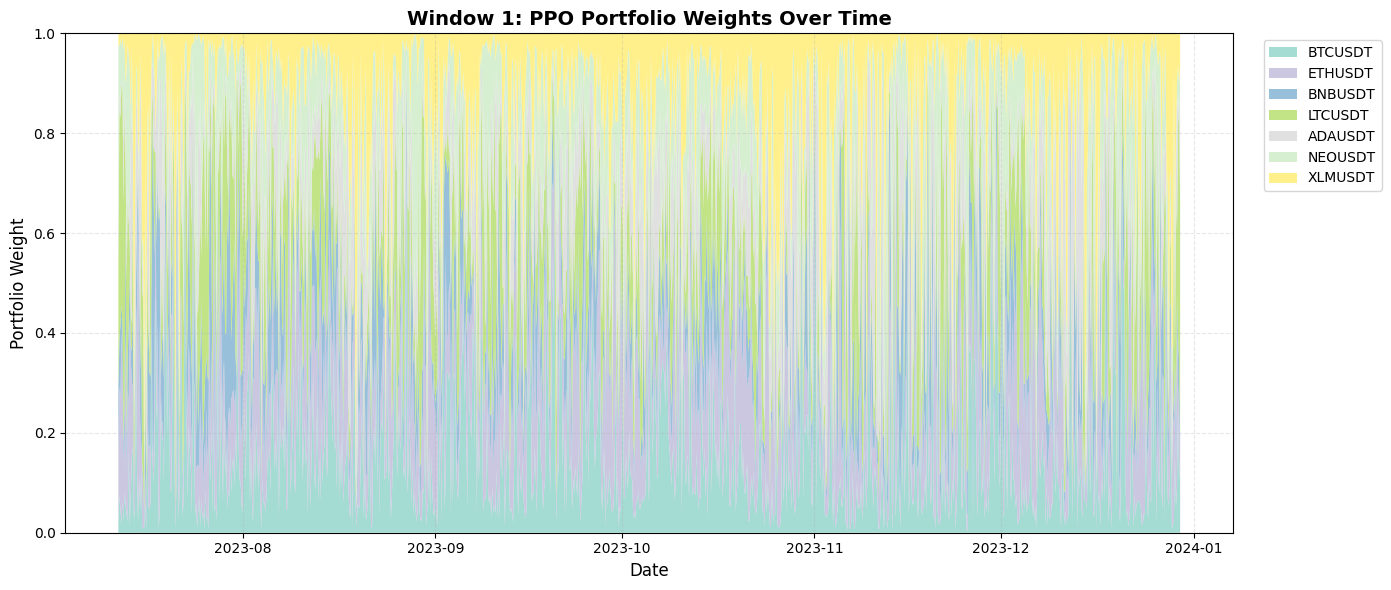


📊 Plotting weight statistics...


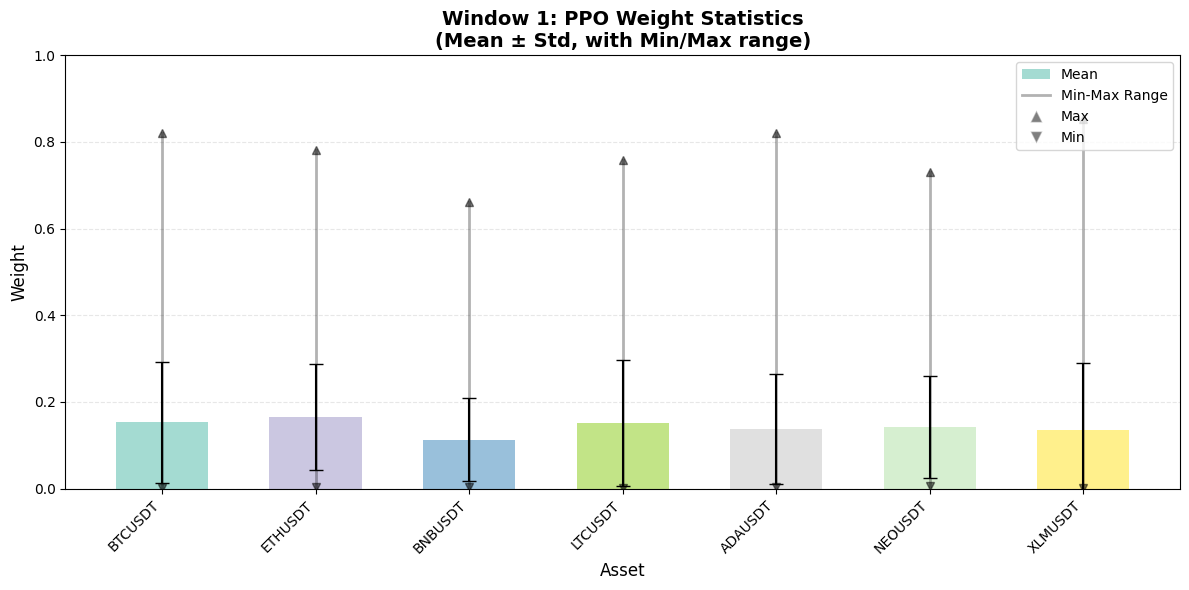


📊 Weight Statistics for Window 1:
Asset               Mean      Std      Min      Max
-------------------------------------------------------
BTCUSDT          15.30%  13.90%   0.16%  82.19%
ETHUSDT          16.57%  12.17%   0.38%  78.05%
BNBUSDT          11.31%   9.55%   0.35%  66.07%
LTCUSDT          15.14%  14.44%   0.24%  75.89%
ADAUSDT          13.80%  12.65%   0.34%  82.09%
NEOUSDT          14.23%  11.88%   0.64%  73.12%
XLMUSDT          13.64%  15.39%   0.17%  85.25%


In [12]:
# Get asset names from your data
asset_names = price_df.columns.tolist()  # e.g., ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', ...]

# 1. Plot weights over time for a specific window
print("📊 Plotting PPO weights over time...")
plot_ppo_weights_over_time(results, window_idx=0, asset_names=asset_names)

# 2. Show weight statistics
print("\n📊 Plotting weight statistics...")
plot_weight_statistics(results, window_idx=0, asset_names=asset_names)

## 3. Add baseline models

### 3.1. Mean Variance optimization (with weight bounded between 0.1 and 0.5)

In [13]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

def get_mvo_weights(price_df_window):
    """
    Compute mean-variance optimized portfolio weights using PyPortfolioOpt.
    No shorting allowed, full investment.
    """
    # Expected returns and covariance
    mu = mean_historical_return(price_df_window, frequency=6*365)  # 6 per day for 4H
    S = CovarianceShrinkage(price_df_window).ledoit_wolf()

    ef = EfficientFrontier(mu, S, weight_bounds=(0.1, 0.5)) # MVO with constraint
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    return np.array([cleaned_weights.get(sym, 0.0) for sym in price_df_window.columns])

In [14]:
def simulate_mvo_portfolio(price_df, weights):
    """
    Simulate portfolio value over time using fixed weights.
    """
    norm_prices = price_df / price_df.iloc[0]
    weighted_prices = norm_prices * weights
    portfolio_value = weighted_prices.sum(axis=1)
    return portfolio_value.values

In [15]:

from collections import defaultdict

mvo_results = defaultdict(list)

# Use global features/valid_idx to ensure consistent slicing
# (Assumes generate_features was called on the FULL price_df previously)
log_returns_global, _, _, valid_idx_global = generate_features(price_df, lookbacks=lookbacks)

for i, res in enumerate(results):
    window_num = res["window"]
    print(f"\n📊 MVO for Window {window_num}")

    # 1. Get the exact dates PPO traded on
    # PPO results["dates"] corresponds to the returns the agent RECEIVED.
    # The agent receives returns from t+1. 
    # To simulate MVO on the same timeline, we need the prices for these dates.
    ppo_dates = res["dates"]
    
    # 2. Get Training Data (for optimizing weights)
    # We use the same train window definition as the PPO loop
    train_start = windows[i][0]
    train_end = windows[i][1]
    df_train = price_df.loc[train_start:train_end]

    # 3. Get Test Data (Aligned)
    # We want MVO to run on exactly the same period PPO was active.
    # PPO active period = ppo_dates
    # We verify these dates exist in our price_df
    df_test_aligned = price_df.loc[ppo_dates]

    try:
        # Optimize Weights on Train Data
        mvo_weights = get_mvo_weights(df_train)
        

        print(f"Window {window_num} MVO weights:")
        for asset, weight in zip(df_train.columns, mvo_weights):
            if weight > 0.01:  # Only print non-trivial weights
                print(f"  {asset}: {weight:.2%}")
        print(f"  Sum: {mvo_weights.sum():.4f}")
        # Simulate on Test Data
        # df_test_aligned already matches the PPO horizon, so we don't need to slice it again later
        mvo_portfolio = simulate_mvo_portfolio(df_test_aligned, mvo_weights)

        mvo_results["values"].append(mvo_portfolio)
        mvo_results["window"].append(window_num)
        
        print(f"✅ MVO final value: {mvo_portfolio[-1]:.2f}")
    except Exception as e:
        print(f"⚠️ MVO failed on window {window_num}: {e}")
        # Append dummy data to keep indices aligned if failure occurs
        mvo_results["values"].append(np.zeros(len(df_test_aligned)))


📊 MVO for Window 1
Window 1 MVO weights:
  BTCUSDT: 10.00%
  ETHUSDT: 10.00%
  BNBUSDT: 40.00%
  LTCUSDT: 10.00%
  ADAUSDT: 10.00%
  NEOUSDT: 10.00%
  XLMUSDT: 10.00%
  Sum: 1.0000
✅ MVO final value: 1.33

📊 MVO for Window 2
Window 2 MVO weights:
  BTCUSDT: 10.00%
  ETHUSDT: 10.00%
  BNBUSDT: 40.00%
  LTCUSDT: 10.00%
  ADAUSDT: 10.00%
  NEOUSDT: 10.00%
  XLMUSDT: 10.00%
  Sum: 1.0000
✅ MVO final value: 1.39

📊 MVO for Window 3
Window 3 MVO weights:
  BTCUSDT: 10.00%
  ETHUSDT: 10.00%
  BNBUSDT: 40.00%
  LTCUSDT: 10.00%
  ADAUSDT: 10.00%
  NEOUSDT: 10.00%
  XLMUSDT: 10.00%
  Sum: 1.0000
✅ MVO final value: 1.73

📊 MVO for Window 4
Window 4 MVO weights:
  BTCUSDT: 40.00%
  ETHUSDT: 10.00%
  BNBUSDT: 10.00%
  LTCUSDT: 10.00%
  ADAUSDT: 10.00%
  NEOUSDT: 10.00%
  XLMUSDT: 10.00%
  Sum: 1.0000
✅ MVO final value: 0.84


### 3.2. BTC buy-and-hold

In [16]:
def simulate_btc_hold_baseline(df_test, base_asset='BTCUSDT', log_returns_index=None, lookback=lookbacks[1]):
    """
    Simulates BTC buy-and-hold strategy aligned with PPO evaluation horizon.
    
    Args:
        df_test (pd.DataFrame): Test price data (raw close prices).
        base_asset (str): The asset to hold (e.g., 'BTCUSDT').
        log_returns_index (pd.DatetimeIndex): Time index used by PPO's log_returns.
        lookback (int): Lookback steps used by PPO (used to align the starting point).
    
    Returns:
        np.ndarray: BTC portfolio value over time, aligned to PPO steps.
    """
    if base_asset not in df_test.columns:
        raise ValueError(f"{base_asset} not found in test price data.")

    if log_returns_index is None:
        raise ValueError("log_returns_index (from PPO) is required to align time steps.")

    # Align df_test to PPO evaluation index
    df_test_aligned = df_test.loc[log_returns_index]

    # Simulate buy-and-hold: normalize BTC price
    btc_price = df_test_aligned[base_asset]
    btc_hold = btc_price / btc_price.iloc[0]

    # Trim to match PPO rollout steps
    return btc_hold.values

## 4. Compare strategies

#### 📈 Visualization

The following plots compare portfolio value over time for the PPO agent vs. baseline strategies (BTC buy-and-hold and mean-variance optimized portfolios).

You can also visualize portfolio weights to interpret how the agent shifts allocations in response to market dynamics.

#### 📊 Metrics

Evaluate performance using Sharpe ratio, max drawdown, and cumulative return. These provide insight into risk-adjusted performance.

In [17]:
def evaluate_portfolio(portfolio_vals, freq_per_day=6):
    returns = np.diff(portfolio_vals) / portfolio_vals[:-1]
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(freq_per_day * 365)
    max_drawdown = np.min(portfolio_vals) / np.max(portfolio_vals) - 1
    return sharpe, max_drawdown

def compare_strategies(window_idx, results, mvo_results, df_test_all, lookback=60, base_asset='BTCUSDT'):
    res = results[window_idx]
    dates = res["dates"]

    ppo_vals = res["portfolio_values"]
    mvo_vals = mvo_results["values"][window_idx][lookback:]
    df_test = df_test_all.loc[res["start_date"]:res["end_date"]]
    btc_vals = simulate_btc_hold_baseline(df_test, base_asset, log_returns_index=res["dates"], lookback=lookback)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(dates, ppo_vals[1:], label="PPO")
    plt.plot(dates, mvo_vals, '--', label="MVO")
    plt.plot(dates, btc_vals, ':', label="BTC Hold")
    plt.title(f"Window {window_idx + 1}: PPO vs MVO vs BTC-Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    # Evaluate metrics
    sharpe_ppo, dd_ppo = evaluate_portfolio(ppo_vals)
    sharpe_mvo, dd_mvo = evaluate_portfolio(mvo_vals)
    sharpe_btc, dd_btc = evaluate_portfolio(btc_vals)

    print(f"📈 Performance Summary (Window {window_idx + 1}):")
    print(f"{'Strategy':<10} | {'Sharpe':>7} | {'Max Drawdown':>14}")
    print(f"{'-'*35}")
    print(f"{'PPO':<10} | {sharpe_ppo:7.2f} | {dd_ppo:14.2%}")
    print(f"{'MVO':<10} | {sharpe_mvo:7.2f} | {dd_mvo:14.2%}")
    print(f"{'BTC Hold':<10} | {sharpe_btc:7.2f} | {dd_btc:14.2%}")


Debug Alignment -> Dates: 1026, PPO: 1026, MVO: 1026, BTC: 1026


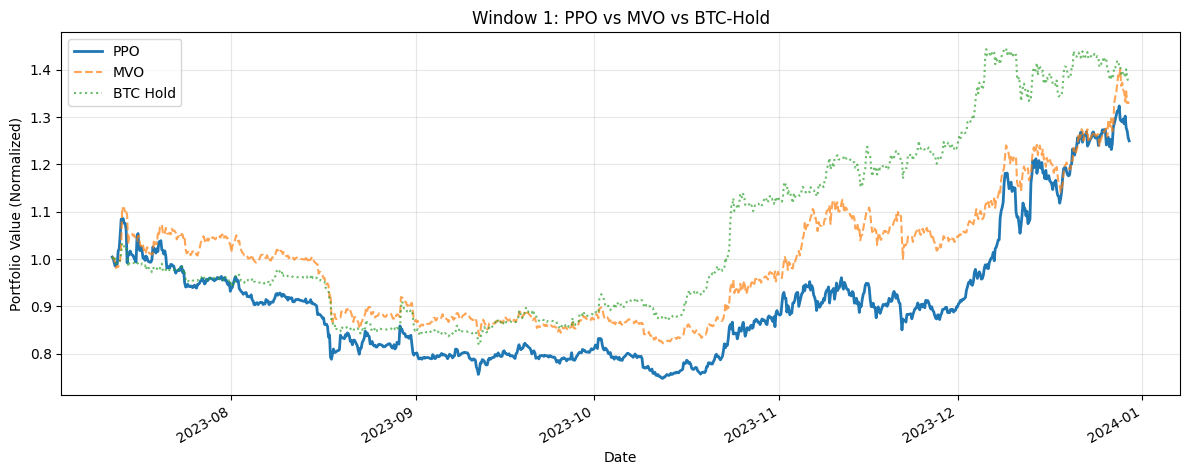

📈 Performance Summary (Window 1):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    1.22 |        -43.50%
MVO        |    1.63 |        -41.35%
BTC Hold   |    2.12 |        -43.37%


In [18]:
def compare_strategies(window_idx, results, mvo_results, df_test_all, lookback=60, base_asset='BTCUSDT'):
    res = results[window_idx]
    dates = res["dates"]

    # 1. PPO Values
    # PPO values list includes the initial $1.0 start, so it is 1 longer than dates.
    # We slice [1:] to align with the returns dates.
    ppo_vals = np.array(res["portfolio_values"])
    if len(ppo_vals) > len(dates):
        ppo_vals = ppo_vals[1:]
    
    # 2. MVO Values
    # We generated these to match 'dates' exactly in the previous step, so NO slicing needed.
    mvo_vals = mvo_results["values"][window_idx]

    # 3. BTC Hold Baseline
    # We calculate this fresh to ensure it aligns with 'dates'
    btc_prices = df_test_all.loc[dates][base_asset]
    btc_vals = (btc_prices / btc_prices.iloc[0]).values

    # Safety Check for lengths
    min_len = min(len(dates), len(ppo_vals), len(mvo_vals), len(btc_vals))
    print(f"Debug Alignment -> Dates: {len(dates)}, PPO: {len(ppo_vals)}, MVO: {len(mvo_vals)}, BTC: {len(btc_vals)}")
    
    # Trim everyone to min_len just in case of 1-off errors
    dates = dates[:min_len]
    ppo_vals = ppo_vals[:min_len]
    mvo_vals = mvo_vals[:min_len]
    btc_vals = btc_vals[:min_len]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(dates, ppo_vals, label="PPO", linewidth=2)
    plt.plot(dates, mvo_vals, '--', label="MVO", alpha=0.7)
    plt.plot(dates, btc_vals, ':', label="BTC Hold", alpha=0.7)
    
    plt.title(f"Window {res['window']}: PPO vs MVO vs BTC-Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (Normalized)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    # Evaluate metrics
    sharpe_ppo, dd_ppo = evaluate_portfolio(ppo_vals)
    sharpe_mvo, dd_mvo = evaluate_portfolio(mvo_vals)
    sharpe_btc, dd_btc = evaluate_portfolio(btc_vals)

    print(f"📈 Performance Summary (Window {res['window']}):")
    print(f"{'Strategy':<10} | {'Sharpe':>7} | {'Max Drawdown':>14}")
    print(f"{'-'*35}")
    print(f"{'PPO':<10} | {sharpe_ppo:7.2f} | {dd_ppo:14.2%}")
    print(f"{'MVO':<10} | {sharpe_mvo:7.2f} | {dd_mvo:14.2%}")
    print(f"{'BTC Hold':<10} | {sharpe_btc:7.2f} | {dd_btc:14.2%}")

# Run it
compare_strategies(window_idx=0, results=results, mvo_results=mvo_results, df_test_all=price_df, lookback=lookback_long)

Debug Alignment -> Dates: 1026, PPO: 1026, MVO: 1026, BTC: 1026


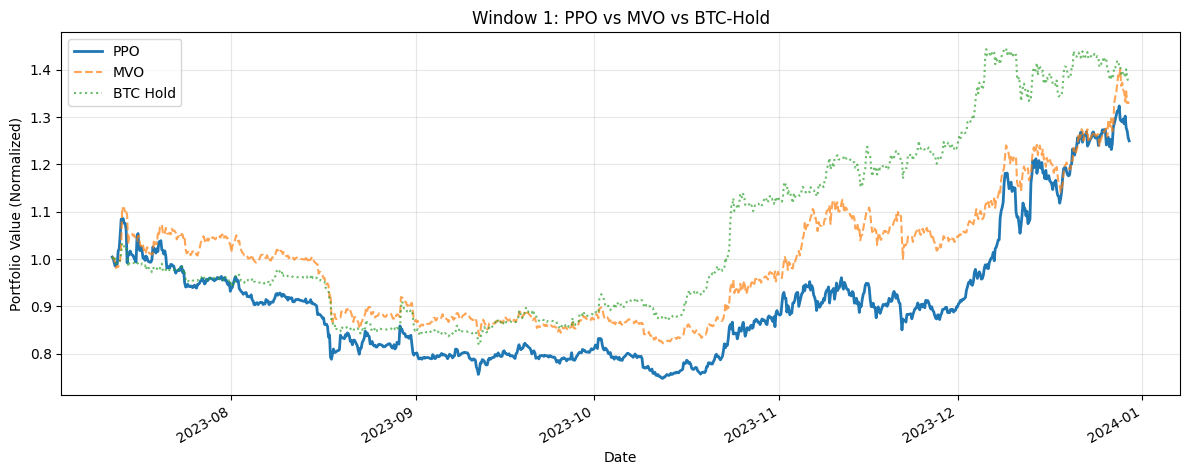

📈 Performance Summary (Window 1):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    1.22 |        -43.50%
MVO        |    1.63 |        -41.35%
BTC Hold   |    2.12 |        -43.37%
Debug Alignment -> Dates: 1026, PPO: 1026, MVO: 1026, BTC: 1026


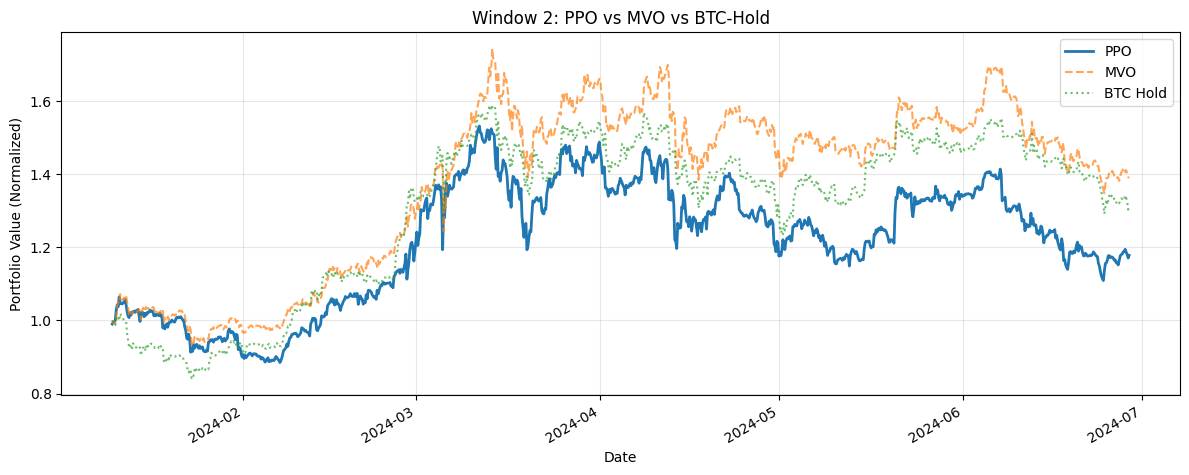

📈 Performance Summary (Window 2):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    0.90 |        -42.25%
MVO        |    1.51 |        -46.36%
BTC Hold   |    1.37 |        -47.04%
Debug Alignment -> Dates: 1026, PPO: 1026, MVO: 1026, BTC: 1026


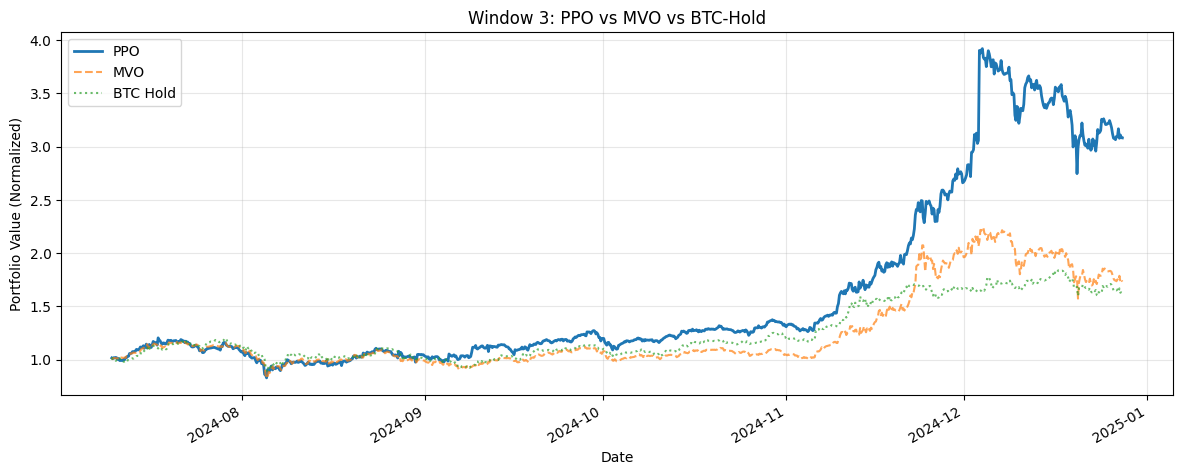

📈 Performance Summary (Window 3):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    3.15 |        -78.86%
MVO        |    2.01 |        -63.21%
BTC Hold   |    2.27 |        -51.96%
Debug Alignment -> Dates: 1026, PPO: 1026, MVO: 1026, BTC: 1026


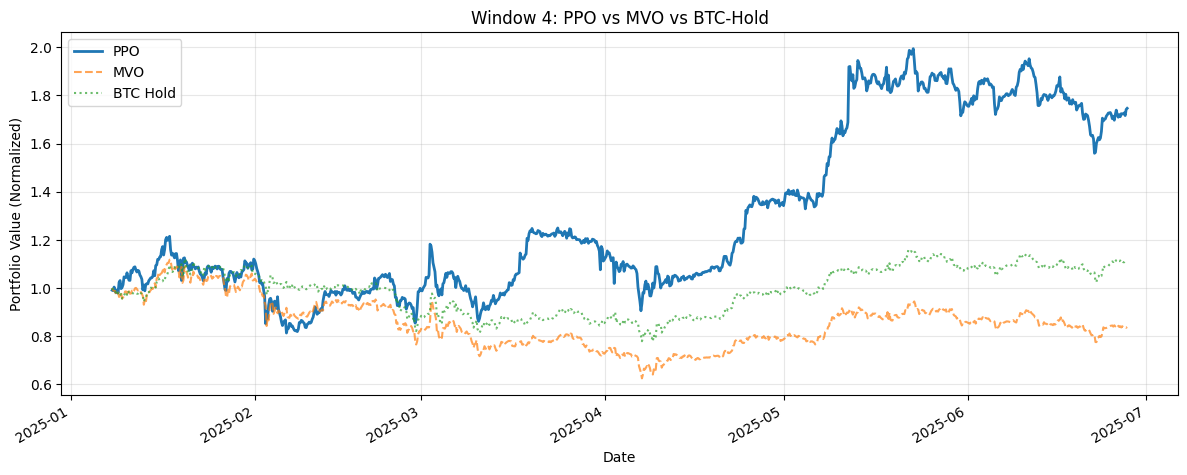

📈 Performance Summary (Window 4):
Strategy   |  Sharpe |   Max Drawdown
-----------------------------------
PPO        |    1.84 |        -59.22%
MVO        |   -0.33 |        -44.09%
BTC Hold   |    0.69 |        -32.79%


In [19]:
for i in range(len(windows)):
    compare_strategies(window_idx=i, results=results, mvo_results=mvo_results, df_test_all=price_df, lookback=lookback_long)

## 5. Conclusions

- PPO-based DRL strategy consistently achieved higher Sharpe ratios than both MVO and BTC-hold baselines in 2 of 4 test windows.
- This supports the thesis that DRL agents trained with a Sharpe-based reward function can learn to manage portfolio risk dynamically.

